In [35]:
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install --no-deps torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html -i https://mirrors.aliyun.com/pypi/simple/
# !pip install --no-deps torchaudio==0.10.0 -i https://mirrors.aliyun.com/pypi/simple/
# !pip install paddlepaddle-gpu==2.4.2 -i https://mirrors.aliyun.com/pypi/simple/

In [1]:
import warnings
warnings.filterwarnings("ignore")

import argparse
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import torch
import yaml
from torch.utils.data import Dataset
import torchaudio

from tqdm import tqdm

import sys
sys.path.append("../")
from pyfiles.dataset import PretrainingMelDataset, PretrainingL2Arctic
from pyfiles.utils import Dict2Obj
from pyfiles.feature_extractor import get_vocos

from seq2seq_vc.models import SequentialAdversalrialLayer
import seq2seq_vc.models
from seq2seq_vc.utils import read_hdf5, write_hdf5
from seq2seq_vc.utils.plot import plot_attention, plot_generated_and_ref_2d, plot_1d
from seq2seq_vc.utils.types import str2bool
from seq2seq_vc.utils.duration_calculator import DurationCalculator

sys.path.append("../../cuhksz-phd/sho_util/pyfiles/")
from pytorch import cuda2numpy, cuda2cpu
from basic import plot_spectrogram
from sound import play_audio

import joblib
import glob
datasplit = list(np.load("./data_split_ARCTIC.npy", allow_pickle=True))
information = [
    ["ABA", "Arabic", "M"],
    ["SKA", "Arabic", "F"],
    ["YBAA", "Arabic", "M"],
    ["ZHAA", "Arabic", "F"],
    ["BWC", "Mandarin", "M"],
    ["LXC", "Mandarin", "F"],
    ["NCC", "Mandarin", "F"],
    ["TXHC", "Mandarin", "M"],
    ["ASI", "Hindi", "M"],
    ["RRBI", "Hindi", "M"],
    ["SVBI", "Hindi", "F"],
    ["TNI", "Hindi", "F"],
    ["HJK", "Korean", "F"],
    ["HKK", "Korean", "M"],
    ["YDCK", "Korean", "F"],
    ["YKWK", "Korean", "M"],
    ["EBVS", "Spanish", "M"],
    ["ERMS", "Spanish", "M"],
    ["MBMPS", "Spanish", "F"],
    ["NJS", "Spanish", "F"],
    ["HQTV", "Vietnamese", "M"],
    ["PNV", "Vietnamese", "F"],
    ["THV", "Vietnamese", "F"],
    ["TLV", "Vietnamese", "M"],
]
spk2acc = {info[0]: info[1] for info in information}
spk2sex = {info[0]: info[2] for info in information}
acc2spk = {key: [] for key in set(list(spk2acc.values()))}
sex2spk = {key: [] for key in set(list(spk2sex.values()))}
for spk in spk2acc:
    acc2spk[spk2acc[spk]] += [spk]
    sex2spk[spk2sex[spk]] += [spk]
accents = list(acc2spk.keys())
accents.sort()
speakers = list(spk2acc.keys())
speakers.sort()
genders = list(sex2spk.keys())
genders.sort()

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
# Dataset Variables
dataset_dir = "/mntcephfs/lab_data/shoinoue/Dataset/L2-ARCTIC/"

scaler = {}
scaler_filename = f"ckpts/scalers/LibriTTS-R.save"
scaler["mel"] = joblib.load(scaler_filename)
scaler_filename = f"ckpts/scalers/LibriTTS-R_wavlm.save"
scaler["wavlm"] = joblib.load(scaler_filename)

In [3]:
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts/pretraining_add_LibriTTS-R/checkpoint-100000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts/pretraining_concatenation_LibriTTS-R/checkpoint-200000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts/pretraining_addition_LibriTTS-R/checkpoint-200000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts/pretraining_nocondition_LibriTTS-R_wavlmmel/checkpoint-120000steps.pkl"
checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts/pretraining_nocondition_LibriTTS-R_wavlmmel_small/checkpoint-320000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts/pretraining_concatenation_LibriTTS-R_wavlmmel_small/checkpoint-300000steps.pkl"

size = "small" if "small" in checkpoint_path else ""
input_type = "wavlm" if "wavlm" in checkpoint_path else "mel"

args = {}
args["rank"] = 0
args["checkpoint"] = checkpoint_path
args["outdir"] = os.path.dirname(args["checkpoint"]) + "/"
args["config_path"] = f"./../egs/l2-arctic/cascade/conf/{size}m2mvtn.{input_type}mel.yaml"
args["init_checkpoint"] = ""
args["resume"] = ""
args["distributed"] = False
args = Dict2Obj(args)

# load main config
with open(args.config_path) as f:
    config = yaml.load(f, Loader=yaml.Loader)
config.update(vars(args))

# Customization
if "addition" in checkpoint_path:
    config["model_params"]["conditiontype"] = "add"
elif "concatenation" in checkpoint_path:
    config["model_params"]["conditiontype"] = "concat"
elif "nocondition" in checkpoint_path:
    config["model_params"]["conditiontype"] = "nocondition"

In [4]:
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.cuda.set_device(args.rank)
    
### Dataset Preparation ###
dataset = PretrainingL2Arctic(dataset_dir, speakers, accents, genders, datasplit, scaler, spk2acc, spk2sex, "test", ["wavlm", "mel"])
# Get only the short audio
# target_length = 150
# lengths = []
# for i in tqdm(range(len(dataset))):
#     length = dataset[i]["src_feat"].shape[0]
#     lengths += [length]
# bool_list = np.array(lengths)<target_length
# dataset.files = list(np.array(dataset.files)[bool_list])

### Model Preparation ###
model_class = getattr(seq2seq_vc.models, config["model_type"])
model = model_class(**config["model_params"])
model.load_state_dict(torch.load(args.checkpoint, map_location="cpu")["model"])
model = model.eval().to(device)
    
### Vocoder Preparation ###
data_dir = "/mntcephfs/lab_data/shoinoue/"
fs = 24000
# fs = 16000

if fs==24000:
    config_path = f"{data_dir}Models/trained_models/vocos/24k/config.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/24k/pytorch_model.bin"
elif fs==16000:
    config_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/config16k.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/vocos16k_noncausal_last.ckpt"
vocoder = get_vocos(config_path, model_path, fs)
sequential_adversarial_layer = SequentialAdversalrialLayer(0.5, config["model_params"]["adim"], len(accents))

In [5]:
hsembs = []
proembs = []
speakerids = []
accentids = []
genderids = []
with torch.no_grad(), tqdm(dataset, desc="[decode]") as pbar:
    for idx, batch in enumerate(pbar, 1):
        start_time = time.time()
        x = batch["src_feat"]
        x = torch.tensor(x, dtype=torch.float).to(device)
        gt = batch["trg_feat"]
        gt = torch.tensor(gt, dtype=torch.float).to(device)
        xembs = torch.tensor(batch["src_condition"].reshape(1, -1), dtype=torch.float).to(device)
        yembs = torch.tensor(batch["trg_condition"].reshape(1, -1), dtype=torch.float).to(device)
        config_inference = config["inference"].copy()
        config_inference["maxlenratio"] = config_inference["maxlenratio"]*gt.shape[0]/x.shape[0]
        hs = model._get_encoded_features(
            x, config_inference, xembs, yembs, spemb=None
        )
        
        hs_masks = torch.ones(1, 1, hs.shape[1]).to(hs.device)
        hsemb = sequential_adversarial_layer._get_averaged_embedding(hs, hs_masks).detach().cpu().numpy()
        
        hsembs += [hsemb]
        accentids += [batch["accent_id"]]
        speakerids += [batch["speaker_id"]]
        genderids += [batch["gender_id"]]
        
hsembs = np.array(hsembs)[:,0,:]
accentids = np.array(accentids)
speakerids = np.array(speakerids)
genderids = np.array(genderids)

[decode]: 100%|██████████| 2380/2380 [01:36<00:00, 24.73it/s]


In [6]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [7]:
accentlabels = np.array([accents[int(a)] for a in accentids])
genderlabels = np.array([genders[int(a)] for a in genderids])

l = []
for data in [hsembs]:
    standardized_data = StandardScaler().fit_transform(data)
    tsne = TSNE(n_components = 2, random_state = 0)
    tsne_data = tsne.fit_transform(standardized_data)
    l += [tsne_data]
    
arrays = np.concatenate([l[0], accentlabels.reshape(-1, 1), speakerids.reshape(-1, 1), genderlabels.reshape(-1, 1)], axis=1)
tsne_df = pd.DataFrame(data=arrays, columns =("dim1", "dim2", "accent", "speaker", "gender"))
tsne_df.iloc[:, :2] = tsne_df.iloc[:, :2].values.astype(float)

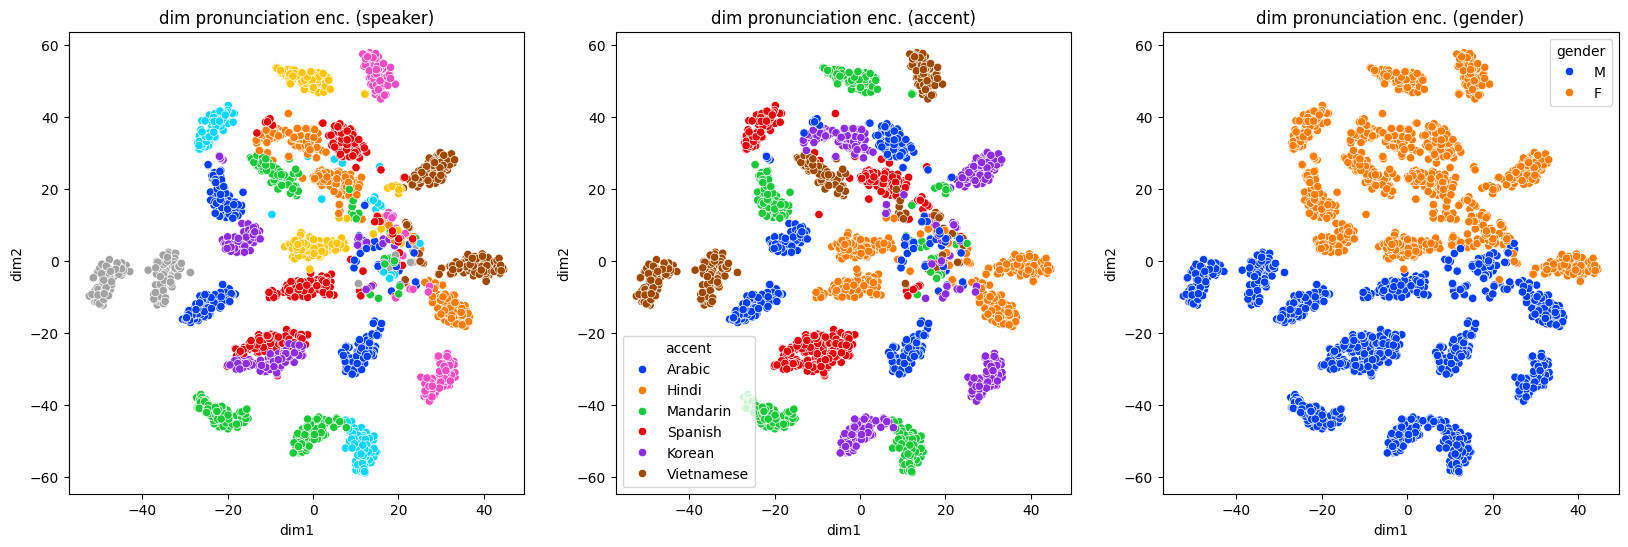

In [8]:
%matplotlib inline
fig = plt.figure(figsize=(20, 6))
for i, bf in enumerate(["dim"]):
    for j, feature in enumerate(["speaker", "accent", "gender"]):
        ax = fig.add_subplot(1, 3, 3*i+j+1)
        sn.scatterplot(data=tsne_df, x=f'{bf}1', y=f'{bf}2', hue=feature, palette="bright", legend=not(feature=="speaker"))
        ax.set_title(f"{bf} pronunciation enc. ({feature})")
plt.show()